In [ ]:
!pip3 install numpy pandas scipy matplotlib
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import re

In [ ]:
if 'TIRA_DATASET_ID' not in os.environ:
    !pip3 install python-terrier tira==0.0.88
else:
    print('We are in the TIRA sandbox.')

In [ ]:
from tira.third_party_integrations import ensure_pyterrier_is_loaded, persist_and_normalize_run

# this loads and starts pyterrier so that it also works in the TIRA
ensure_pyterrier_is_loaded()

# PyTerrier must be imported after the call to ensure_pyterrier_is_loaded in TIRA.
import pyterrier as pt

In [ ]:
from tira.rest_api_client import Client
tira_client = Client()

### Unsere Retrieval Pipeline

In [5]:
TASK = "ir-lab-jena-leipzig-wise-2023"
TEAM = "geometric-tortoise"
APPROACHES = [
    "fast-upload",   # no-query-expansion
    "recent-cordon"  # query-expansion
]
DATASET = "jena-topics-20231026-test"

In [6]:
data = pt.get_dataset(f'irds:{TASK}/{DATASET}')

Load ir_dataset "ir-lab-jena-leipzig-wise-2023/jena-topics-20231026-test" from tira.


In [7]:
our_runs = [
    tira_client.pt.from_retriever_submission(
        f'{TASK}/{TEAM}/{approach}', DATASET)
    for approach in APPROACHES
]

In [ ]:
topics = data.get_topics()
topics.head()

In [9]:
# Calculation of the number of words in the title
topics["word_count_old"] = topics["title"].map(lambda x: x.count(" ")+1)
# Calculation of the number of characters in the title
topics["length"] = topics["title"].map(lambda x: len(x))

# Calculation of the number of words in the title using the pyterrier tokenizer
# https://pyterrier.readthedocs.io/en/latest/text.html#working-with-passages-rather-than-documents : r'\s+' instead of ' '
topics["word_count"] = topics["title"].map(lambda x: len(re.split(r'\s+', x)))

topics.head()

,qid,text,title,query,description,narrative,word_count_old,length,word_count
0,1,the frequency of solar storms with impact on e...,the frequency of solar storms with impact on e...,the frequency of solar storms with impact on e...,\n How often do solar storms occur which ...,\n Scientific publications or articles wh...,12,71,12
1,2,popular pastries in germany,popular pastries in germany,popular pastries in germany,\n Which are the best-selling pastries in...,"\n Find statistics, news articles or othe...",4,27,4
2,3,flights Frankfurt to Rome,flights Frankfurt to Rome,flights frankfurt to rome,\n Show flight connections from Frankfurt...,\n Relevant are all future flight connect...,4,25,4
3,4,remove wine stains,remove wine stains,remove wine stains,\n How can wine stains be removed?\n,\n Relevant is all information about wine...,3,18,3
4,5,tipping in us,tipping in us,tipping in us,\n What tipping is considered appropriate...,\n We ask for some guidelines of how to c...,3,13,3


In [10]:
# Calulation of the Threshold
topics["word_count"] = topics["title"].map(lambda x: x.count(" ")+1)
threshold = topics["word_count"].median()
if len(topics[topics["word_count"] > threshold]) > len(topics[topics["word_count"] < threshold]):
    topics["is_long"] = topics["word_count"] > threshold
else:
    topics["is_long"] = topics["word_count"] >= threshold

In [ ]:
# Experiment over all topics and the two pipelines
experiment = pt.Experiment(
    our_runs,
    topics, data.get_qrels(),
    ["ndcg_cut_5"],
    [
        "ohne QE",
        "mit QE",
    ],
    perquery=True
)

In [12]:
# merge the topics with the results
eval_all = experiment.merge(topics, on="qid")
eval_all.head()

,name,qid,measure,value,text,title,query,description,narrative,word_count_old,length,word_count,is_long
0,mit QE,1,ndcg_cut_5,0.000000,the frequency of solar storms with impact on e...,the frequency of solar storms with impact on e...,the frequency of solar storms with impact on e...,\n How often do solar storms occur which ...,\n Scientific publications or articles wh...,12,71,12,True
1,mit QE,10,ndcg_cut_5,0.000000,lost my keys what now,lost my keys what now,lost my keys what now,\n What can be done if you lose your apar...,\n Relevant is all information on how to ...,5,21,5,True
2,mit QE,11,ndcg_cut_5,0.131205,an apple everyday healthy?,an apple everyday healthy?,an apple everyday healthy,\n What effects does eating an apple ever...,\n Show scientific publications and healt...,4,26,4,True
3,mit QE,12,ndcg_cut_5,0.699215,what temperature for green tea,what temperature for green tea,what temperature for green tea,\n What is the optimal temperature for th...,\n Find resources which explain which tem...,5,30,5,True
4,mit QE,13,ndcg_cut_5,0.000000,probability of snow in december in jena,probability of snow in december in jena,probability of snow in december in jena,\n How high is the probability that there...,\n Find publications about the weather in...,7,39,7,True


In [13]:
# combine the results of the two pipelines into one dataframe
without_qe = eval_all[eval_all["name"] == "ohne QE"][["qid", "value"]]
with_qe = eval_all[eval_all["name"] == "mit QE"][["qid", "value"]]

eval = topics.copy()
eval["ndcg_without_qe"] = eval["qid"].map(without_qe.set_index("qid")["value"])
eval["ndcg_with_qe"] = eval["qid"].map(with_qe.set_index("qid")["value"])

eval.head()

,qid,text,title,query,description,narrative,word_count_old,length,word_count,is_long,ndcg_without_qe,ndcg_with_qe
0,1,the frequency of solar storms with impact on e...,the frequency of solar storms with impact on e...,the frequency of solar storms with impact on e...,\n How often do solar storms occur which ...,\n Scientific publications or articles wh...,12,71,12,True,0.146068,0.000000
1,2,popular pastries in germany,popular pastries in germany,popular pastries in germany,\n Which are the best-selling pastries in...,"\n Find statistics, news articles or othe...",4,27,4,True,0.485229,0.213986
2,3,flights Frankfurt to Rome,flights Frankfurt to Rome,flights frankfurt to rome,\n Show flight connections from Frankfurt...,\n Relevant are all future flight connect...,4,25,4,True,0.000000,0.000000
3,4,remove wine stains,remove wine stains,remove wine stains,\n How can wine stains be removed?\n,\n Relevant is all information about wine...,3,18,3,False,0.654809,0.830420
4,5,tipping in us,tipping in us,tipping in us,\n What tipping is considered appropriate...,\n We ask for some guidelines of how to c...,3,13,3,False,0.000000,0.000000


In [14]:
eval["diff_improvement"] = eval["ndcg_with_qe"] - eval["ndcg_without_qe"]
eval.head()

,qid,text,title,query,description,narrative,word_count_old,length,word_count,is_long,ndcg_without_qe,ndcg_with_qe,diff_improvement
0,1,the frequency of solar storms with impact on e...,the frequency of solar storms with impact on e...,the frequency of solar storms with impact on e...,\n How often do solar storms occur which ...,\n Scientific publications or articles wh...,12,71,12,True,0.146068,0.000000,-0.146068
1,2,popular pastries in germany,popular pastries in germany,popular pastries in germany,\n Which are the best-selling pastries in...,"\n Find statistics, news articles or othe...",4,27,4,True,0.485229,0.213986,-0.271242
2,3,flights Frankfurt to Rome,flights Frankfurt to Rome,flights frankfurt to rome,\n Show flight connections from Frankfurt...,\n Relevant are all future flight connect...,4,25,4,True,0.000000,0.000000,0.000000
3,4,remove wine stains,remove wine stains,remove wine stains,\n How can wine stains be removed?\n,\n Relevant is all information about wine...,3,18,3,False,0.654809,0.830420,0.175611
4,5,tipping in us,tipping in us,tipping in us,\n What tipping is considered appropriate...,\n We ask for some guidelines of how to c...,3,13,3,False,0.000000,0.000000,0.000000


##### Overall Improvement

In [18]:
ndcg_cut_5_all = eval[['ndcg_without_qe', 'ndcg_with_qe']].mean()
print(f"diff_improvement: {ndcg_cut_5_all['ndcg_with_qe'] - ndcg_cut_5_all['ndcg_without_qe']}")

diff_improvement: -0.015706353062649725


##### Improvement for short and long queries

In [19]:
# average diff_improvement
eval[["is_long", "diff_improvement"]].groupby("is_long").mean()

,diff_improvement
is_long,
False,-0.022523
True,-0.010026


array([[<Axes: title={'center': 'diff_improvement'}>]], dtype=object)

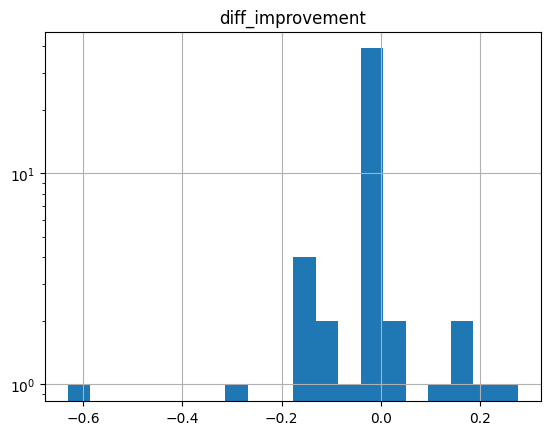

In [26]:
eval.hist(column="diff_improvement", bins=20, log=[True, False])

### Hypothesentest

##### Hypothesen:
1. Die Differenz der Effektivität (ndcg@5) zwischen Retrieval ohne query expansion und mit query expansion bei kleinen Anfragen unterscheidet sich signifikant (Signifikanzlevel von 5%).
2. **Die Differenz der Effektivität (ndcg@5) zwischen Retrieval ohne query expansion und mit query expansion ist bei kleinen Anfragen signifikant größer als bei großen Anfragen mit Signifikanzlevel von 5%.**
3. Die Differenz der Effektivität (ndcg@5) zwischen Retrieval ohne query expansion und mit query expansion ist bei kleinen Anfragen signifikant kleiner als bei großen Anfragen mit Signifikanzlevel von 5%.

In [20]:
# necessary Data
short_improvement = list(eval[eval["is_long"] == False]["diff_improvement"])
long_improvement = list(eval[eval["is_long"] == True]["diff_improvement"])
print(f"short_improvement: {str(short_improvement)[:100]}...")
print(f"long_improvement: {str(long_improvement)[:100]}...")


short_improvement: [0.1756112396100613, 0.0, 0.0, -0.16958010263680806, -0.169580102636808, 0.0, -0.1756112396100613, 0...
long_improvement: [-0.14606834984270645, -0.27124229038179504, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14606834984270645, 0.0,...


In [21]:
# Perform a two-sample t-test

ttest_results = pd.DataFrame([
    ["Two-sided", *stats.ttest_ind(short_improvement, long_improvement), 0.05],
    ["One-sided (greater)", *stats.ttest_ind(short_improvement, long_improvement, alternative="greater"), 0.025],
    ["One-sided (less)", *stats.ttest_ind(short_improvement, long_improvement, alternative="less"), 0.025]], 
    columns=["T-Test", "T-statistic", "P-value", "necessary significance"], 
    index=["Hypothesis 1", "Hypothesis 2", "Hypothesis 3"])
# From https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html:
# This is a test for the null hypothesis that 2 independent samples have identical 
# average (expected) values. This test assumes that the populations have identical 
# variances by default.

ttest_results["accepted"] = ttest_results["P-value"] < ttest_results["necessary significance"]

ttest_results

,T-Test,T-statistic,P-value,necessary significance,accepted
Hypothesis 1,Two-sided,-0.377184,0.707543,0.050,False
Hypothesis 2,One-sided (greater),-0.377184,0.646228,0.025,False
Hypothesis 3,One-sided (less),-0.377184,0.353772,0.025,False


In [22]:
# output the results of the t-test to a file
ttest_results.to_csv("ttest_results.csv")